# MODULES

You may need the following to run the notebook

    Folium version: 0.14.0
    Numpy version: 1.23.5
    Pandas version: 1.5.3
    Geopandas version: 0.13.2
    Matplotlib version: 3.7.1
    Seaborn version: 0.11.2
    Scikit-Learn version: 1.3.1

In [1]:
#UNCOMMENT TO INSTALL THROUGH COLAB IF NOT YET INSTALLED
#!pip install folium==0.14.0 numpy==1.23.5 pandas==1.5.3 geopandas==0.13.2 matplotlib==3.7.1 
#!pip install seaborn==0.11.2 scikit-learn==1.3.1

In [2]:
seed=777
import os 
import time
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import reverse_geocoder as rg
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.metrics import mean_squared_error,accuracy_score, roc_auc_score,f1_score,confusion_matrix

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor,CatBoostClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier

# READ DATASETS

**TRAIN**

In [3]:
# Read the data from a CSV file called "Train.csv" and store it in the 'train' dataframe
train = pd.read_csv("Train.csv")

# Convert the 'date' column to a datetime format
train["date"] = pd.to_datetime(train["date"])

# Create a new 'lat_lng' column by rounding 'lat' and 'lng' to 0 decimal places and combining them as strings
train['lat_lng'] = round(train['lat'], 0).astype(str) + "_" + round(train['lng'], 0).astype(str)

# Remove duplicate rows in the dataframe based on all columns except for "ID"
train.drop_duplicates(subset=[col for col in train.columns if col != "ID"], inplace=True)

# Print the shape of the 'train' dataframe, indicating the number of rows and columns
print("shape of train: ", train.shape)

# Display the first 2 rows of the 'train' dataframe
train.head(2)

shape of train:  (120368, 63)


,ID,date,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,type,pm25,pm10,o3,so2,no2,pm25_aqi,pm10_aqi,no2_aqi,o3_aqi,so2_aqi,aqi,utm_x,utm_y,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,lat_lng
0,ID_000000,2016-01-01,45.49678,9.257515,1.536364,0.0,84.608392,52.440559,65.918955,0.916667,0.416667,0.891304,1.205952,1.005556,1.1475,1.46,1.470968,NS,73.122701,86.0,4.379167,5.939789,41.958333,5,4,2,1,1,5,520119.96871,5.038171e+06,120.367,84.649254,12,1,180.0,0.257589,-0.039992,0.20006,25.495098,0.184223,-2.521106,0.083804,9.651856,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0_9.0
1,ID_000001,2016-01-01,45.49678,9.257515,1.536364,0.0,84.608392,52.440559,65.918955,0.916667,0.416667,0.891304,1.205952,1.005556,1.1475,1.46,1.470968,NS,73.122701,86.0,4.379167,5.939789,41.958333,5,4,2,1,1,5,520119.96871,5.038171e+06,120.367,84.649254,12,1,180.0,0.257589,-0.039992,0.20006,25.495098,0.184223,-2.521106,0.083804,9.651856,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0_9.0


**TEST**

In [4]:
# Read the test data from a CSV file called "test.csv" and store it in the 'test' dataframe
test = pd.read_csv("test.csv")

# Remove the 'Unnamed: 0' column from the 'test' dataframe
test.drop("Unnamed: 0", axis=1, inplace=True)

# Create new 'lat_lng' column in the 'test' dataframe by rounding 'lat' and 'lng' to 0 dp and combining them as strings
test['lat_lng'] = round(test['lat'], 0).astype(str) + "_" + round(test['lng'], 0).astype(str)

# Store the 'ID' column from the 'test' dataframe in a separate 'test_ids' variable
test_ids = test.ID

# Print the shape of the 'test' dataframe, indicating the number of rows and columns
print("shape of test: ", test.shape)

# Display the first 2 rows of the 'test' dataframe
test.head(2)


shape of test:  (160, 5)


,ID,lat,lng,season,lat_lng
0,ID_000000,45.171919,9.488997,1,45.0_9.0
1,ID_000001,45.171919,9.488997,2,45.0_9.0


**SEASONAL DATASETS**

In [5]:
# winter season
meteo_winter_2022=pd.read_csv("meteo_winter_2022.csv")
meteo_winter_2022.drop("Unnamed: 0",axis=1,inplace=True)

# spring season
meteo_spring_2022=pd.read_csv("meteo_spring_2022.csv")
meteo_spring_2022.drop("Unnamed: 0",axis=1,inplace=True)

#summer season
meteo_summer_2022=pd.read_csv("meteo_summer_2022.csv")
meteo_summer_2022.drop("Unnamed: 0",axis=1,inplace=True)

# autumn season
meteo_autumn_2022=pd.read_csv("meteo_autumn_2022.csv")
meteo_autumn_2022.drop("Unnamed: 0",axis=1,inplace=True)

#ALL SEASONAL DATA HAS SAME ROWS NUMBER OF ROWS AND HAS SIMILAR COLUMNS  SO WE COMBINE THEM!
combined_seasons=pd.concat([meteo_winter_2022,meteo_spring_2022,meteo_summer_2022,meteo_autumn_2022])
combined_seasons['lat_lng']=round(combined_seasons['lat'],0).astype(str)+"_"+round(combined_seasons['lng'],\
                                                                                   0).astype(str)
print("shape of combined seasons: ",combined_seasons.shape)
combined_seasons.head(3)

shape of combined seasons:  (75300, 20)


,geometry,centroids,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,season,year,lat,lng,lat_lng
0,"POLYGON ((9.26855823284458 45.51528894334295, ...",POINT (9.269196238518438 45.514837385933276),11.567649,81.932863,67.857619,140.634885,40.643590,1.852600,1.563738,1.927561,1.941793,1.481755,1.420310,1.721075,1.744621,1,2022,45.514837,9.269196,46.0_9.0
1,POLYGON ((9.267273668864517 45.514391844757135...,POINT (9.267915945752094 45.51484039588496),11.532532,81.880813,67.817645,140.635367,40.651990,1.853156,1.563748,1.927534,1.942350,1.482065,1.421587,1.722182,1.746384,1,2022,45.514840,9.267916,46.0_9.0
2,"POLYGON ((9.265993386000206 45.51439483313846,...",POINT (9.266635652783668 45.514843391487496),11.493360,81.815894,67.774043,140.634680,40.645017,1.853798,1.563936,1.927992,1.943308,1.482948,1.423902,1.724144,1.748598,1,2022,45.514843,9.266636,46.0_9.0


**AIR POLLUTION LEVELS DATASETS**

In [6]:
# Read the air pollution data from the CSV file into a DataFrame
air_pollution = pd.read_csv("air_pollution_Milan_Comune_topo_only.csv")

# Print the shape of the 'air_pollution' DataFrame
print("shape of air_pollution: ", air_pollution.shape)

# Create a new 'lat_lng' column by rounding the 'lat' and 'lng' columns and combining them as strings
air_pollution['lat_lng'] = round(air_pollution['lat'], 0).astype(str) + "_" + round(air_pollution['lng'], 0).astype(str)

# Remove duplicate rows in the 'air_pollution' DataFrame
air_pollution.drop_duplicates(inplace=True)

# Display the first 3 rows of the 'air_pollution' DataFrame
air_pollution.head(3)

shape of air_pollution:  (18825, 36)


,geometry,lat,lng,y,x,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,lat_lng
0,POINT (9.269196238518438 45.51483738593328),45.514837,9.269196,5040182.5,521027.5,127.225,98.52649,23,1,180.0,0.638918,-0.500966,0.543071,65.192024,0.347598,-1.886195,0.262420,9.016946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0
1,POINT (9.267915945752094 45.51484039588496),45.514840,9.267916,5040182.5,520927.5,127.254,235.39381,23,1,181.0,0.509539,-1.119995,0.276001,5.000000,0.696074,-11.318421,0.393017,7.629353,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0
2,POINT (9.266635652783668 45.514843391487496),45.514843,9.266636,5040182.5,520827.5,127.592,211.70203,12,1,172.0,0.414239,0.998159,-4.997874,15.811388,8.549326,-8.802861,2.479467,5.113790,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0


# EDA

In [7]:
# All latitudes in test are in train but not longitudes
print("total latitudes in train and test:",test.lat.isin(train.lat).sum())
print("total longitudes in train and test:",test.lng.isin(train.lat).sum())
print("total lat_lng in train and test:",test.lat_lng.isin(train.lat_lng).sum())

total latitudes in train and test: 160
total longitudes in train and test: 0
total lat_lng in train and test: 160


In [8]:
# Neither latitudes or longitudes in the train are in air pollution dataset
print("total latitudes in train and air-pollution:",train.lat.isin(air_pollution.lat).sum())
print("total longitudes in train and air-pollution:",train.lng.isin(air_pollution.lat).sum())
print("total lat_lng in train and air-pollution:",train.lat_lng.isin(air_pollution.lat_lng).sum())

total latitudes in train and air-pollution: 0
total longitudes in train and air-pollution: 0
total lat_lng in train and air-pollution: 113142


In [9]:
# Neither latitudes or longitudes in the test are in air pollution dataset
print("total latitudes in test and air-pollution:",test.lat.isin(air_pollution.lat).sum())
print("total longitudes in test and air-pollution:",test.lng.isin(air_pollution.lat).sum())
print("total lat_lng in test and air-pollution:",test.lat_lng.isin(air_pollution.lat_lng).sum())

total latitudes in test and air-pollution: 0
total longitudes in test and air-pollution: 0
total lat_lng in test and air-pollution: 152


In [10]:
# Neither latitudes or longitudes in the train are in seasonal dataset
print("total latitudes in train and the seasonal datasets:",train.lat.isin(combined_seasons.lat).sum())
print("total longitudes in train and the seasonal datasets:",train.lng.isin(combined_seasons.lat).sum())
print("total lat_lng in train and the seasonal datasets:",train.lat_lng.isin(combined_seasons.lat_lng).sum())

total latitudes in train and the seasonal datasets: 0
total longitudes in train and the seasonal datasets: 0
total lat_lng in train and the seasonal datasets: 113142


In [11]:
#Neither latitudes or longitudes in the test are in seasonal dataset
print("total latitudes in test and the seasonal datasets:",test.lat.isin(combined_seasons.lat).sum())
print("total longitudes in test and the seasonal datasets:",test.lng.isin(combined_seasons.lat).sum())
print("total lat_lng in test and the seasonal datasets:",test.lat_lng.isin(combined_seasons.lat_lng).sum())

total latitudes in test and the seasonal datasets: 0
total longitudes in test and the seasonal datasets: 0
total lat_lng in test and the seasonal datasets: 152


In [12]:
# all longitudes and latitudes in air pollution level datasets are in the seasonals datasets!
print("total latitudes in air pollution and the seasonal datasets:",air_pollution.lat.isin(combined_seasons.lat).sum())
print("total longitudes in air pollution and the seasonal dataset:",air_pollution.lng.isin(combined_seasons.lng).sum())
print("total lat_lng in air pollution and the seasonal :",air_pollution.lat_lng.isin(combined_seasons.lat_lng).sum())

total latitudes in air pollution and the seasonal datasets: 18825
total longitudes in air pollution and the seasonal dataset: 18825
total lat_lng in air pollution and the seasonal : 18825


In [13]:
#All train data is from 2016-2021
print("Min year for the train dataset:",train.date.dt.year.min())
print("Maximum year for the train dataset:",train.date.dt.year.max())

Min year for the train dataset: 2016
Maximum year for the train dataset: 2021


In [14]:
#All data for the combined_seasons is from 2022 - we are to predict AQI for test points for same period
print("Min year for the seasonal datasets:",combined_seasons.year.min())
print("Maximum year for the seasonal datasets:",combined_seasons.year.max())

Min year for the seasonal datasets: 2022
Maximum year for the seasonal datasets: 2022


In [15]:
display(air_pollution.head(2), # name of dataset a little confusion because it contains 
       combined_seasons.head(2))

,geometry,lat,lng,y,x,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,lat_lng
0,POINT (9.269196238518438 45.51483738593328),45.514837,9.269196,5040182.5,521027.5,127.225,98.52649,23,1,180.0,0.638918,-0.500966,0.543071,65.192024,0.347598,-1.886195,0.262420,9.016946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0
1,POINT (9.267915945752094 45.51484039588496),45.514840,9.267916,5040182.5,520927.5,127.254,235.39381,23,1,181.0,0.509539,-1.119995,0.276001,5.000000,0.696074,-11.318421,0.393017,7.629353,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0


,geometry,centroids,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,season,year,lat,lng,lat_lng
0,"POLYGON ((9.26855823284458 45.51528894334295, ...",POINT (9.269196238518438 45.514837385933276),11.567649,81.932863,67.857619,140.634885,40.64359,1.852600,1.563738,1.927561,1.941793,1.481755,1.420310,1.721075,1.744621,1,2022,45.514837,9.269196,46.0_9.0
1,POLYGON ((9.267273668864517 45.514391844757135...,POINT (9.267915945752094 45.51484039588496),11.532532,81.880813,67.817645,140.635367,40.65199,1.853156,1.563748,1.927534,1.942350,1.482065,1.421587,1.722182,1.746384,1,2022,45.514840,9.267916,46.0_9.0


In [16]:
# We will therefore can combine the seasonal datasets with air pollution as they have common longitudes and latitudes
comb_air=combined_seasons.merge(air_pollution,on=["lat","lng","lat_lng","geometry"],how="left")
print("shape of combined seasons: ",comb_air.shape)
comb_air.head(3)

shape of combined seasons:  (75300, 53)


,geometry,centroids,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,season,year,lat,lng,lat_lng,y,x,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51
0,"POLYGON ((9.26855823284458 45.51528894334295, ...",POINT (9.269196238518438 45.514837385933276),11.567649,81.932863,67.857619,140.634885,40.643590,1.852600,1.563738,1.927561,1.941793,1.481755,1.420310,1.721075,1.744621,1,2022,45.514837,9.269196,46.0_9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POLYGON ((9.267273668864517 45.514391844757135...,POINT (9.267915945752094 45.51484039588496),11.532532,81.880813,67.817645,140.635367,40.651990,1.853156,1.563748,1.927534,1.942350,1.482065,1.421587,1.722182,1.746384,1,2022,45.514840,9.267916,46.0_9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((9.265993386000206 45.51439483313846,...",POINT (9.266635652783668 45.514843391487496),11.493360,81.815894,67.774043,140.634680,40.645017,1.853798,1.563936,1.927992,1.943308,1.482948,1.423902,1.724144,1.748598,1,2022,45.514843,9.266636,46.0_9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DATA PRE-PROCESSING

In [17]:
# Since test has only lat, long features we interporlate -we do this using combined dataset
# we arleady saw that the seasonal datasets in combined datasest hare for year 2022
# Define a custom IDW interpolation function
def idw_interpolation(x, y, values, xi, yi, power=2):
    distances = np.sqrt((xi - x) ** 2 + (yi - y) ** 2)
    weights = 1.0 / (distances ** power)
    weighted_values = values * weights
    return weighted_values.sum() / weights.sum()

# Create an empty DataFrame to store interpolated values
interpolated_data = test[['lat', 'lng']].copy()

# Iterate through the columns you want to interpolate
columns_to_interpolate = [col for col in comb_air.columns if col not in test.columns.union(["geometry", 
                                                                                            "centroids", "lat_lng"])]

# Set the power parameter for IDW (you can adjust this value)
power = 2

for col in columns_to_interpolate:
    # Check if the column exists in comb_air
    if col in comb_air.columns:
        # Perform the IDW interpolation
        interpolated_values = [
            idw_interpolation(comb_air['lat'], comb_air['lng'], comb_air[col], lat, lng, power)
            for lat, lng in zip(test['lat'], test['lng'])
        ]
        # Add the interpolated values to the DataFrame
        test[col] = interpolated_values

# Now, test DataFrame contains IDW interpolated values
print('Not Interporlated: ',len(test[test.temperature.isnull()]))
print('Interporlated: ',len(test[~test.temperature.isnull()]))
test.head()#"""

Not Interporlated:  0
Interporlated:  160


,ID,lat,lng,season,lat_lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,year,y,x,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51
0,ID_000000,45.171919,9.488997,1,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_000001,45.171919,9.488997,2,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ID_000002,45.171919,9.488997,3,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ID_000003,45.171919,9.488997,4,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ID_000004,45.281956,8.988563,1,45.0_9.0,16.162231,98.729142,66.228187,165.644745,36.198364,1.856491,1.762562,2.466993,2.450797,2.153527,2.248906,1.895779,1.623322,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Check how many columns in the 'comb_air' dataset are also present in the 'test' dataset
print("total columns in com air and in test:", comb_air.columns.isin(test.columns).sum(), "\n")

# Check how many columns in the 'test' dataset are also present in the 'train' dataset
#print("total columns in test and train:", test.columns.isin(train.columns).sum(), "\n")

# Find the common columns that exist in both the 'train' and 'comb_air' datasets
common_cols = [col for col in train.columns if col in test.columns]
print("Total common columns in train & test:", "\t", len(common_cols), '\n', common_cols, "\n")

# Find the columns that are in 'train' but not in 'comb_air'
not_common_cols = [col for col in train.columns if col not in comb_air.columns]
print("Total not common columns in train & test:", "\t", len(not_common_cols), '\n', not_common_cols)

# Check how many columns in the 'comb_air' dataset are also present in the 'test' dataset
print("\ntotal columns in train alone:", len(train.columns))
print("\ntotal columns in test alone:", len(test.columns))

total columns in com air and in test: 51 

Total common columns in train & test: 	 48 
 ['ID', 'lat', 'lng', 'temperature', 'precipitation', 'humidity', 'global_radiation', 'hydrometric_level', 'N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'dtm_milan', 'aspect', 'dusaf15', 'geologia', 'hillshade', 'ndvi_2019', 'plan_curvature', 'profile_curvature', 'water_distance', 'slope', 'spi', 'tri', 'twi', 'geo_0', 'geo_1', 'geo_2', 'geo_3', 'geo_4', 'geo_5', 'geo_6', 'lc_11', 'lc_12', 'lc_14', 'lc_21', 'lc_22', 'lc_23', 'lc_31', 'lc_32', 'lc_33', 'lc_41', 'lc_51', 'lat_lng'] 

Total not common columns in train & test: 	 16 
 ['ID', 'date', 'type', 'pm25', 'pm10', 'o3', 'so2', 'no2', 'pm25_aqi', 'pm10_aqi', 'no2_aqi', 'o3_aqi', 'so2_aqi', 'aqi', 'utm_x', 'utm_y']

total columns in train alone: 63

total columns in test alone: 52


# FEATURE ENGINEERING

**SEASON FEATURE**

In [19]:
train["month"] = train["date"].dt.month
train["season"] = train["month"].map({
                                        1: 1, 2: 1, 3: 1,    # Months 1, 2, 3 belong to season 1
                                        4: 2, 5: 2, 6: 2,    # Months 4, 5, 6 belong to season 2
                                        7: 3, 8: 3, 9: 3,    # Months 7, 8, 9 belong to season 3
                                        10: 4, 11: 4, 12: 4  # Months 10, 11, 12 belong to season 4
                                    })
train.tail()

,ID,date,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,type,pm25,pm10,o3,so2,no2,pm25_aqi,pm10_aqi,no2_aqi,o3_aqi,so2_aqi,aqi,utm_x,utm_y,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,lat_lng,month,season
121648,ID_121648,2021-12-30,45.396195,9.282700,4.068290,0.018870,98.841926,31.136746,49.847023,1.102796,1.076272,1.607448,1.464914,0.976055,1.115676,1.328953,1.211017,UT,35.277410,37.848238,2.362500,2.195479,40.554167,4,2,2,1,1,4,522126.993940,5.027003e+06,98.33748,81.273820,11,1,180.0,0.400000,-0.110519,0.020218,25.00000,0.247792,-1.531532,0.060948,9.760875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0_9.0,12,4
121649,ID_121649,2021-12-31,45.523426,9.044600,2.058015,0.098848,99.243918,52.115708,23.179946,0.806201,0.485191,0.611951,0.618859,1.197694,1.369756,1.317538,1.031706,UB,36.501711,38.148888,5.337500,2.357237,38.783333,4,2,1,1,1,4,503483.010045,5.041100e+06,151.78000,169.570970,12,1,178.0,0.098690,0.238851,-0.277140,71.58911,1.028138,-10.928314,0.240213,7.239246,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0,12,4
121650,ID_121650,2021-12-31,45.552326,9.227764,3.027432,0.005722,97.639251,54.555107,19.551793,0.751813,0.703680,0.577904,1.053680,1.184131,1.419823,1.332128,0.947827,UT,43.123672,43.912197,5.337500,2.147439,59.070833,4,3,2,1,1,4,517777.981725,5.044335e+06,149.67400,282.297900,12,1,189.0,0.443687,-0.585386,-0.341368,1668.59230,3.251062,0.350555,0.812581,6.780195,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0_9.0,12,4
121651,ID_121651,2021-12-31,45.443858,9.167945,3.726027,0.008928,97.957254,59.206698,49.125161,1.047037,0.588793,0.783190,0.528735,1.288881,1.379505,1.258999,1.000181,UT,31.561594,31.172364,1.613043,2.526705,41.329167,4,2,2,1,1,4,513134.038886,5.032273e+06,113.49300,19.005035,12,0,184.0,0.186638,0.010948,2.139030,15.00000,2.277274,5.445005,0.739729,11.898918,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0_9.0,12,4
121652,ID_121652,2021-12-31,45.396195,9.282700,3.196689,0.037551,97.587888,52.566477,49.669836,1.031876,0.628661,0.754957,0.640057,1.175428,1.278475,1.285059,1.084499,UT,36.349442,37.687640,2.300000,2.477681,39.212500,4,2,1,1,1,4,522126.993940,5.027003e+06,98.33748,81.273820,11,1,180.0,0.400000,-0.110519,0.020218,25.00000,0.247792,-1.531532,0.060948,9.760875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0_9.0,12,4


**ROTATIONAL FEATURES**

In [20]:
def rotation(data):
    '''
    # Rotate latitude (x) and longitude (y) coordinates by 45 and 30 degrees.
    input: dataframe containing Latitude(x) and longitude(y)
    '''
    rot_45_x = (0.707 * data['lat']) + (0.707 * data['lng'])
    rot_45_y = (0.707 * data['lng']) + (0.707 * data['lat'])
    rot_30_x = (0.866 * data['lat']) + (0.5 * data['lng'])
    rot_30_y = (0.866 * data['lng']) + (0.5 * data['lat'])
    return rot_45_x, rot_45_y, rot_30_x, rot_30_y

# Apply the rotation function to the train dataset
rot_45_x_train, rot_45_y_train, rot_30_x_train, rot_30_y_train = rotation(train)

# Apply the rotation function to the test dataset
rot_45_x_test, rot_45_y_test, rot_30_x_test, rot_30_y_test = rotation(test)

# Add new features to train dataset
train['rot_45_x'] = rot_45_x_train
train['rot_45_y'] = rot_45_y_train
train['rot_30_x'] = rot_30_x_train
train['rot_30_y'] = rot_30_y_train

# Add new features to test dataset
test['rot_45_x'] = rot_45_x_test
test['rot_45_y'] = rot_45_y_test
test['rot_30_x'] = rot_30_x_test
test['rot_30_y'] = rot_30_y_test
test.head()

,ID,lat,lng,season,lat_lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,year,y,x,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,rot_45_x,rot_45_y,rot_30_x,rot_30_y
0,ID_000000,45.171919,9.488997,1,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.863380,30.803431
1,ID_000001,45.171919,9.488997,2,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.863380,30.803431
2,ID_000002,45.171919,9.488997,3,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.863380,30.803431
3,ID_000003,45.171919,9.488997,4,45.0_9.0,16.241170,97.204067,65.442072,165.447240,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.863380,30.803431
4,ID_000004,45.281956,8.988563,1,45.0_9.0,16.162231,98.729142,66.228187,165.644745,36.198364,1.856491,1.762562,2.466993,2.450797,2.153527,2.248906,1.895779,1.623322,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.369257,38.369257,43.708455,30.425074


**GET THE NAMES OF PLACES, COUNTY AND STATES**

In [21]:
def geocoder(data):
    '''
    input: dataframe containing Latitude(lat) and lnggitude(lng) coordinates
    output: dataframe with additional columns for place information
    '''
    # Convert DataFrame to a list of tuples
    coordinates = list(zip(data['lat'], data['lng']))
    
    results = rg.search(coordinates)  # default mode = 2

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Rename columns to more meaningful names
    results_df.rename(columns={'name': 'place_name', 'admin1': 'state', 'admin2': 'county'}, inplace=True)

    # Concatenate the results with the original data
    data_with_places = pd.concat([data, results_df], axis=1)

    return data_with_places

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Apply the geocoder function to your train and test datasets
train = geocoder(train)
test = geocoder(test)

train.columns=train.columns[:-6:].tolist()+['lati', 'long', 'place_name', 'state', 'county', 'cc']
test.columns=test.columns[:-6:].tolist()+['lati', 'long', 'place_name', 'state', 'county', 'cc']

print(train.shape,test.shape)
test.head(3)

Loading formatted geocoded file...
(120368, 75) (160, 62)


,ID,lat,lng,season,lat_lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,year,y,x,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,geo_0,geo_1,geo_2,geo_3,geo_4,geo_5,geo_6,lc_11,lc_12,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,rot_45_x,rot_45_y,rot_30_x,rot_30_y,lati,long,place_name,state,county,cc
0,ID_000000,45.171919,9.488997,1,45.0_9.0,16.24117,97.204067,65.442072,165.44724,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.86338,30.803431,45.18322,9.49028,San Colombano al Lambro,Lombardy,Citta metropolitana di Milano,IT
1,ID_000001,45.171919,9.488997,2,45.0_9.0,16.24117,97.204067,65.442072,165.44724,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.86338,30.803431,45.18322,9.49028,San Colombano al Lambro,Lombardy,Citta metropolitana di Milano,IT
2,ID_000002,45.171919,9.488997,3,45.0_9.0,16.24117,97.204067,65.442072,165.44724,38.829897,1.899242,1.760902,2.462576,2.414661,2.112113,2.265842,1.966492,1.713227,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.645268,38.645268,43.86338,30.803431,45.18322,9.49028,San Colombano al Lambro,Lombardy,Citta metropolitana di Milano,IT


In [22]:
common_cols = [col for col in train.columns if col in test.columns.union(["aqi"])]
len(common_cols)

60

**LABEL ENCODE OBJECT COLUMNS**

In [23]:
categorical_cols=train.select_dtypes(["object"]).columns.tolist()
categorical_cols=[col for col in categorical_cols if col not in ["ID","date"]]
#categorical_cols=[col for col in categorical_cols if col  in ["id",'time']]

# Initialize LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    train[col]= label_encoder.fit_transform(train[col])
    if col!="type":
        test[col]= label_encoder.fit_transform(test[col]) #"""

In [24]:
# Filter and keep only the numeric columns in the 'train' DataFrame
train = train.select_dtypes(include=['float64', 'int64', 'int32'])

# Filter and keep only the numeric columns in the 'test' DataFrame
test = test.select_dtypes(include=['float64', 'int64', 'int32'])

In [25]:
# there were not duplicates in train 
print(train.shape)
train.drop_duplicates(inplace=True)
print(train.shape)

(120368, 73)
(120368, 73)


In [26]:
# dropping or filling null features did not work, so we will later use models that can handle missing values
#train.isna().sum()

**SCALE COLUMNS**

In [27]:
# Define a function 'scale_columns' to perform Min-Max scaling on selected columns of a DataFrame.
def scale_columns(df):
    # Initialize a MinMaxScaler.
    scaler = MinMaxScaler()
    
    # Define a list of columns to exclude from scaling.
    cols_to_exclude = ["aqi", "ID","date"]
    
    # Create a list of columns to scale by excluding those in 'cols_to_exclude'.
    cols_to_scale = [col for col in df.columns if col not in cols_to_exclude]
    
    # Apply Min-Max scaling to the selected columns and store the scaled values.
    scaled_values = scaler.fit_transform(df[cols_to_scale])
    
    # Create a copy of the DataFrame and replace the original columns with scaled values.
    scaled_df = df.copy()
    scaled_df[cols_to_scale] = scaled_values
    
    return scaled_df

# Apply the 'scale_columns' function to scale the 'train2' DataFrame.
train = scale_columns(train)

# Apply the 'scale_columns' function to scale the 'test' DataFrame.
test = scale_columns(test)

# MODELLING

In [28]:
# Various final data in the datasets
meteorological_timeseries = ['lat', 'lng', 'temperature', 'precipitation', 'humidity', 
                             'global_radiation', 'hydrometric_level']

land_cover_maps = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW',  'lc_11', 'lc_12', 'lc_14', 
                   'lc_21', 'lc_22', 'lc_23', 'lc_31', 'lc_32', 'lc_33', 'lc_41', 'lc_51'] # #'utm_x', 'utm_y','type'

digital_terrain_model = ['dtm_milan', 'aspect', 'hillshade', 'plan_curvature', 'profile_curvature',
                         'water_distance', 'slope', 'spi', 'tri', 'twi'] # topographic features

geological_map = ['geologia', 'geo_0', 'geo_1', 'geo_2', 'geo_3', 'geo_4', 'geo_5', 'geo_6']

# air pollution columns missing in test-not relevant
air_pollution = ['pm25', 'pm10', 'o3', 'so2', 'no2', 'pm25_aqi', 'pm10_aqi', 'no2_aqi', 'o3_aqi', 'so2_aqi', 'aqi']


engineered_features=[ 'season', 'rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y','lati', 
'long', 'place_name', 'state', 'county', 'cc','lat_lon'] #'month',

In [29]:
# Create a list of column names common to both 'train' and 'test' DataFrames, including 'aqi'.
common_cols = [col for col in train.columns if col in test.columns.union(["aqi"])]

# Create a copy of the 'train' DataFrame and name it 'train2'.
train2 = train.copy()

# Select only the columns listed in 'common_cols' in the 'train2' DataFrame.
train2 = train2[common_cols]
#train2=train2[['season','aqi','lat','lng']] #uncomment if you want to see effect of no interporlation

# Extract the 'aqi' column from 'train2' as the target variable 'y'.
y = train2["aqi"]

# Create a list of columns to drop, including those starting with 'geo_' or 'lc_'.
columns_to_drop = [col for col in train2.columns if col.startswith(('geo_', 'lc_'))] #remove-trial show they degrade results
#columns_to_drop = [] # uncomment to checks performance on whole data

# Drop the identified columns and the 'aqi' column from the 'train2' DataFrame.
train2.drop(columns_to_drop + ["aqi"], axis=1, inplace=True)
#train2=train2[engineered_features] #uncomment if you want to see performance on engineered features only
#train2=train2[digital_terrain_model] #uncomment if you want to see performance on digital_terrain_model features only
#train2=train2[land_cover_maps] #uncomment if you want to see performance on land_cover_maps features only
#train2=train2[meteorological_timeseries] #uncomment if you want performance on meteorological_timeseries features only
#train2=train2[geological_map] #uncomment if you want performance on geological_map features only

# Display the first few rows of the modified 'train2' DataFrame.
print(train2.shape)
train2.head()

(120368, 40)


,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,E,SE,S,SW,W,NW,dtm_milan,aspect,dusaf15,geologia,hillshade,ndvi_2019,plan_curvature,profile_curvature,water_distance,slope,spi,tri,twi,lat_lng,season,rot_45_x,rot_45_y,rot_30_x,rot_30_y,lati,long,place_name,state,county,cc
0,0.735357,0.668415,0.209560,0.000000e+00,0.792661,0.064284,0.565146,0.074019,0.035613,0.090869,0.117083,0.109657,0.098227,0.113939,0.145706,0.306072,0.206811,0.025,0.25,0.485437,0.235171,0.547737,0.512623,0.015279,0.006755,0.543806,0.013700,0.390806,0.0,0.0,0.572038,0.572038,0.585881,0.612978,0.487179,0.794872,1.000000,0.0,0.0,0.0
1,0.735357,0.668415,0.209560,0.000000e+00,0.792661,0.064284,0.565146,0.074019,0.035613,0.090869,0.117083,0.109657,0.098227,0.113939,0.145706,0.306072,0.206811,0.025,0.25,0.485437,0.235171,0.547737,0.512623,0.015279,0.006755,0.543806,0.013700,0.390806,0.0,0.0,0.572038,0.572038,0.585881,0.612978,0.487179,0.794872,1.000000,0.0,0.0,0.0
2,0.000000,0.965383,0.209192,1.407911e-20,0.964486,0.028463,0.289087,0.118431,0.139226,0.161847,0.106493,0.124548,0.202155,0.199113,0.144248,0.457042,0.414895,0.275,1.00,0.368932,0.693606,0.581301,0.473645,0.705791,0.185543,0.166413,0.169394,0.104861,0.0,0.0,0.463302,0.463302,0.283194,0.666410,0.000000,0.948718,0.794872,0.0,0.0,0.0
3,0.000000,0.965383,0.209192,0.000000e+00,0.964486,0.028463,0.289087,0.118431,0.139226,0.161847,0.106493,0.124548,0.202155,0.199113,0.144248,0.457042,0.414895,0.275,1.00,0.368932,0.693606,0.581301,0.473645,0.705791,0.185543,0.166413,0.169394,0.104861,0.0,0.0,0.463302,0.463302,0.283194,0.666410,0.000000,0.948718,0.794872,0.0,0.0,0.0
4,0.249080,0.323376,0.216645,0.000000e+00,0.964176,0.028969,0.285593,0.075029,0.119658,0.106369,0.101672,0.127118,0.124406,0.091914,0.081812,0.140857,0.349612,0.075,0.00,0.475728,0.103262,0.489298,0.522686,0.011986,0.023884,0.891806,0.056289,0.660880,0.0,0.0,0.008700,0.008700,0.000000,0.134858,0.025641,0.230769,0.538462,0.0,0.0,0.0


In [30]:
# Count the occurrences of each unique value in the target variable "y"
y.value_counts()

2    59783
4    28249
3    14954
5     9767
1     6233
6     1382
Name: aqi, dtype: int64

**CATBOOST**

In [31]:
%%time
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train2, y, test_size=0.2, random_state=seed)

# Define the model
model = CatBoostClassifier(random_state=seed, verbose=500)  # default parameters

# Cross-validation
k = 5
performance_metrics = []
#kf = KFold(n_splits=k, shuffle=True, random_state=0)
kf = KFold(n_splits=k, shuffle=True,random_state=seed)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    performance_metrics.append((accuracy)) 
average_accuracy = np.mean(performance_metrics)
print("Average accuracy from cross-validation: ", average_accuracy)
#model.fit(train2, y)
test_predictions = model.predict(test[train2.columns])

# Add index to results
predictions_df = pd.DataFrame({'ID': test_ids, 'aqi': test_predictions.reshape(-1)})
predictions_df.to_csv("1.catboost.csv", index=False)
print(predictions_df["aqi"].value_counts())
predictions_df.head()

Learning rate set to 0.098752
0:	learn: 1.6392521	total: 267ms	remaining: 4m 27s
500:	learn: 0.6734720	total: 31.6s	remaining: 31.4s
999:	learn: 0.5305116	total: 1m 1s	remaining: 0us
Learning rate set to 0.098752
0:	learn: 1.6397272	total: 88.6ms	remaining: 1m 28s
500:	learn: 0.6740272	total: 32.1s	remaining: 32s
999:	learn: 0.5310879	total: 1m 6s	remaining: 0us
Learning rate set to 0.098752
0:	learn: 1.6399930	total: 80.5ms	remaining: 1m 20s
500:	learn: 0.6749692	total: 39.8s	remaining: 39.7s
999:	learn: 0.5363260	total: 1m 20s	remaining: 0us
Learning rate set to 0.098752
0:	learn: 1.6401606	total: 117ms	remaining: 1m 56s
500:	learn: 0.6790860	total: 37.6s	remaining: 37.5s
999:	learn: 0.5334344	total: 1m 17s	remaining: 0us
Learning rate set to 0.098752
0:	learn: 1.6377536	total: 85.1ms	remaining: 1m 24s
500:	learn: 0.6741542	total: 38.3s	remaining: 38.2s
999:	learn: 0.5316965	total: 1m 18s	remaining: 0us
Average accuracy from cross-validation:  0.7685317727591888
2    98
4    60
3    

,ID,aqi
0,ID_000000,4
1,ID_000001,2
2,ID_000002,2
3,ID_000003,4
4,ID_000004,4


In [32]:
%%time
# test inference
input_data = np.array(X_train.iloc[0]).reshape(1, -1) # Reshape the input data -one sample
# Make the prediction
model.predict(input_data)

Wall time: 3.63 ms


array([[4]], dtype=int64)

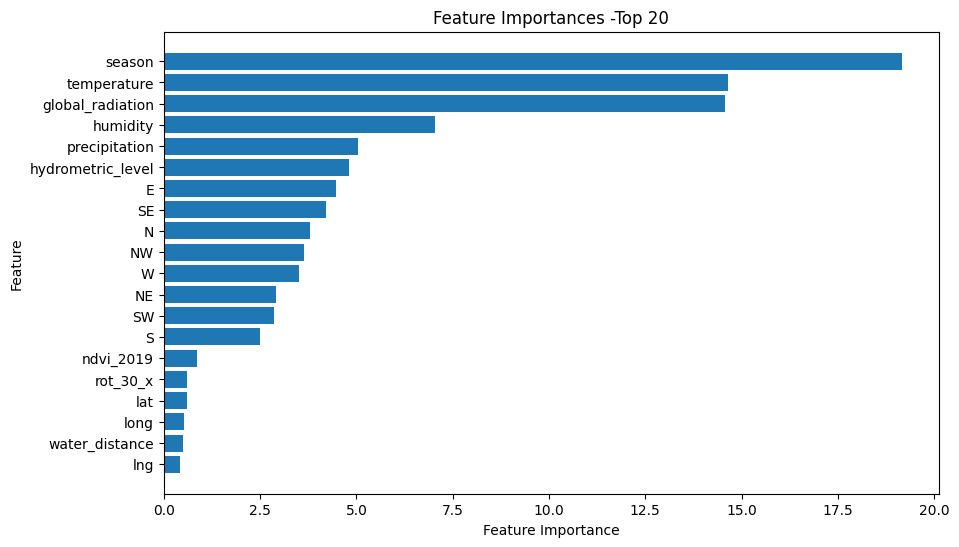

In [33]:
# Calculate feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
feature_importance_df=feature_importance_df.tail(20)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances -Top 20')
plt.show()

**HISTGRADIENT BOOSTING**

In [34]:
%%time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train2, y, test_size=0.2, random_state=seed)

# Define the HistGradientBoosting model
model = HistGradientBoostingClassifier(random_state=seed, verbose=0)  # default parameters

# Cross-validation
k = 5
performance_metrics = []
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    performance_metrics.append(accuracy) 
average_accuracy = np.mean(performance_metrics)
print("Average accuracy from cross-validation: ", average_accuracy)

#model.fit(train2, y)
test_predictions = model.predict(test[train2.columns])

# Add index to results
predictions_df = pd.DataFrame({'ID': test_ids, 'aqi': test_predictions})
predictions_df.to_csv("1.histgradientboosting.csv", index=False)
print(predictions_df["aqi"].value_counts())
predictions_df.head()

C:\Users\PC\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Average accuracy from cross-validation:  0.7470454737903268
2    99
4    52
5     7
3     2
Name: aqi, dtype: int64
Wall time: 1min 5s


,ID,aqi
0,ID_000000,4
1,ID_000001,2
2,ID_000002,2
3,ID_000003,4
4,ID_000004,4


In [35]:
%%time
# test inference
input_data = np.array(X_train.iloc[0]).reshape(1, -1) # Reshape the input data -one sample
# Make the prediction
model.predict(input_data)

Wall time: 22.9 ms


C:\Users\PC\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([4], dtype=int64)

**LIGHTGBM**

In [36]:
start=time.time()
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train2, y, test_size=0.2, random_state=seed)

# Define the LGBM model
model = lgb.LGBMClassifier(random_state=seed, verbose=0)  # default parameters

# Cross-validation
k = 5
performance_metrics = []
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    performance_metrics.append(accuracy) 
average_accuracy = np.mean(performance_metrics)
print("Average accuracy from cross-validation: ", average_accuracy)

#model.fit(train2, y)
stop=time.time()
print('time taken to fit model: ',stop-start,'seconds')

test_predictions = model.predict(test[train2.columns])

# Add index to results
predictions_df = pd.DataFrame({'ID': test_ids, 'aqi': test_predictions})
predictions_df.to_csv("1.lgbm.csv", index=False)
print(predictions_df["aqi"].value_counts())
predictions_df.head()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022141 seconds.
You can set `force_col_wise=true` to remove the overhead.
Average accuracy from cross-validation:  0.7384364551260185
time taken to fit model:  31.682294607162476 seconds
2    89
4    62
5     6
1     3
Name: aqi, dtype: int64


,ID,aqi
0,ID_000000,4
1,ID_000001,2
2,ID_000002,2
3,ID_000003,4
4,ID_000004,4


In [37]:
# Start measuring time
start_time = time.time()

# test inference 
input_data = np.array(X_train.iloc[0]).reshape(1, -1)  # Reshape the input data - one sample to 2D

# Make the prediction
print(model.predict(input_data))

# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Convert to microseconds
elapsed_time_microseconds = elapsed_time * 1_000_000

# Convert to milliseconds
elapsed_time_milliseconds = elapsed_time * 1_000

print(f"Elapsed time: {elapsed_time} seconds")
print(f"Elapsed time: {elapsed_time_microseconds} microseconds (µs)")
print(f"Elapsed time: {elapsed_time_milliseconds} milliseconds (ms)")

[4]
Elapsed time: 0.0029909610748291016 seconds
Elapsed time: 2990.9610748291016 microseconds (µs)
Elapsed time: 2.9909610748291016 milliseconds (ms)


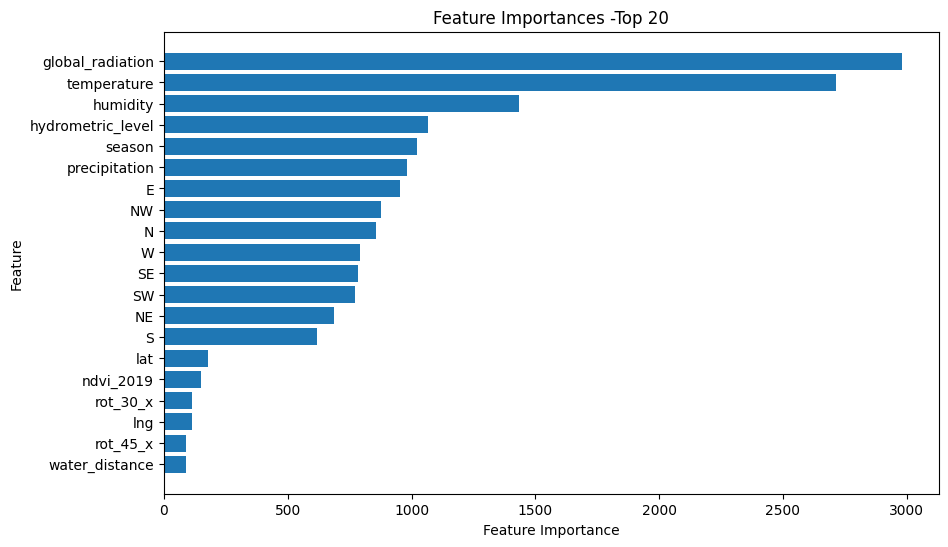

In [38]:
# Calculate feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
feature_importance_df=feature_importance_df.tail(20)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances -Top 20')
plt.show()

**XGBOOST**

In [39]:
yy=y.replace({1:0,
          2:1,
          3:2,
          4:3,
          5:4,
          6:5})

In [40]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train2, yy, test_size=0.2, random_state=seed)

# Define the XGBoost model
model = xgb.XGBClassifier(random_state=seed, verbosity=1)  # default parameters

# Cross-validation
k = 5
performance_metrics = []
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    performance_metrics.append(accuracy) 
average_accuracy = np.mean(performance_metrics)
print("Average accuracy from cross-validation: ", average_accuracy)

#model.fit(train2, yy)
test_predictions = model.predict(test[train2.columns])
# Define a dictionary to reverse the mapping
reverse_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6}
# Use a list comprehension to apply the reverse mapping
test_predictions = [reverse_mapping[val] for val in test_predictions]

# Add index to results
predictions_df = pd.DataFrame({'ID': test_ids, 'aqi': test_predictions})
predictions_df.to_csv("1.xgboost.csv", index=False)
print(predictions_df["aqi"].value_counts())
predictions_df.head()

Average accuracy from cross-validation:  0.7743991977218506
4    71
2    71
1     9
3     6
5     3
Name: aqi, dtype: int64
Wall time: 10min 34s


,ID,aqi
0,ID_000000,4
1,ID_000001,2
2,ID_000002,2
3,ID_000003,4
4,ID_000004,4


In [41]:
%%time
# test inference
input_data = np.array(X_train.iloc[0]).reshape(1, -1) # Reshape the input data -one sample
# Make the prediction
model.predict(input_data)

Wall time: 3.39 ms


array([3], dtype=int64)

**Get Feature Importances**

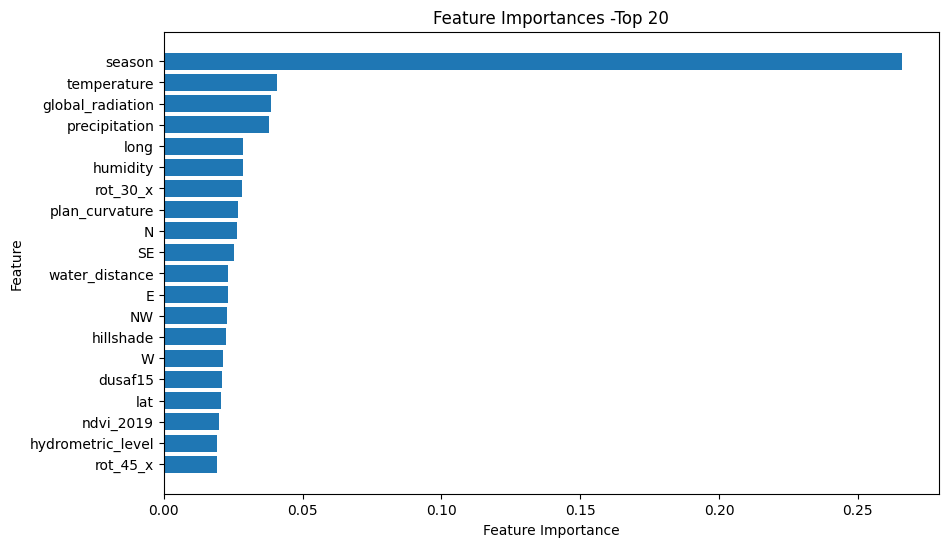

In [42]:
# Calculate feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
feature_importance_df=feature_importance_df.tail(20)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances -Top 20')
plt.show()

In [43]:
catboost = pd.read_csv("1.Catboost.csv")
lgbm = pd.read_csv("1.lgbm.csv")
xgb = pd.read_csv("1.xgboost.csv")
hist = pd.read_csv("1.histgradientboosting.csv")

ensemble = pd.DataFrame()
ensemble["ID"] = catboost["ID"]

predictions_data = pd.concat([catboost["aqi"],
                              lgbm["aqi"],
                              xgb["aqi"],
                              hist["aqi"]],
                             axis=1)
ensemble["aqi"] = predictions_data.mode(axis=1)[0].astype(int)
print(ensemble["aqi"].value_counts().astype(int))
ensemble.to_csv('1.ensemble_mode.csv', index=False)
ensemble.head()

2    98
4    59
1     3
Name: aqi, dtype: int32


,ID,aqi
0,ID_000000,4
1,ID_000001,2
2,ID_000002,2
3,ID_000003,4
4,ID_000004,4


# End